In [1]:
import numpy as np

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset
from l5kit.rasterization import build_rasterizer

import os
import copy
from itertools import cycle, combinations

import sys
sys.path.append('../..')

import backpack

In [2]:
os.environ['L5KIT_DATA_FOLDER'] = '../../dataset'
dm = LocalDataManager(None)

cfg = load_config_data('./config.yaml')
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False}, 'train_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': True, 'num_workers': 16}, 'val_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}, 'train_params': {'checkpoint_every_n_steps': 10000, 'max_num_steps': 5, 'eval_every_n_steps': 10000}}


In [3]:
train_cfg = cfg['train_data_loader']
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg['key'])).open()

In [4]:
def map_frame_array_to_dict(array):
    return dict(zip(['timestamp', 'agent_index_interval', 'ego_rotation', 'ego_translation'], array))

def map_scene_array_to_dict(array):
    return dict(zip(['frame_index_interval', 'host', 'start_time', 'end_time'], array))

def map_agent_array_to_dict(array):
    return dict(zip(['centroid', 'extent', 'yaw', 'velocity', 'track_id', 'label_probabilities'], array))

In [5]:
scenes = [map_scene_array_to_dict(s) for s in train_zarr.scenes]
frames = [map_frame_array_to_dict(f) for f in train_zarr.frames]
agents = [map_agent_array_to_dict(a) for a in train_zarr.agents]

In [6]:
# playing around with scene 99
scene_i = 99
scene = scenes[scene_i]
scene

{'frame_index_interval': array([24590, 24838]),
 'host': 'host-a101',
 'start_time': 1571844710505151232,
 'end_time': 1571844735505151232}

In [7]:
clusters = []

fii = scene['frame_index_interval']
for frame in frames[fii[0]: fii[1]]:
    
    c = backpack.Cluster(frame, agents)
    c.normalize_data()
    c.agglomerative_cluster(n_clusters=6)
    c.generate_relative_motion_matrices()
    c.generate_average_relative_motions()

    clusters.append(c)

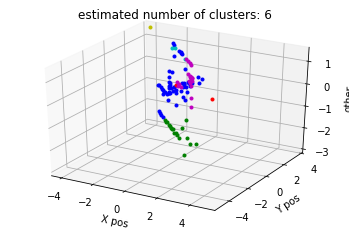

In [8]:
clusters[99].plot(other=4)

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

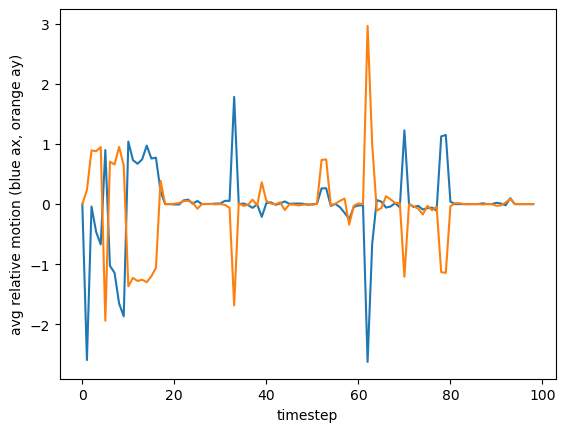

In [50]:
yeet = []
vx = []
vy = []

agent_i = 20

for i in range(99):
    yeet.append(np.linalg.norm(clusters[i].average_relative_motions[agent_i]))
    vx.append(clusters[i].average_relative_motions[agent_i][0])
    vy.append(clusters[i].average_relative_motions[agent_i][1]) 
    
yeet = np.array(yeet)

ax = plt.axes()

ax.set_xlabel('timestep')
ax.set_ylabel('avg relative motion (blue ax, orange ay)')

ax.plot(list(range(99)), vx)
ax.plot(list(range(99)), vy)

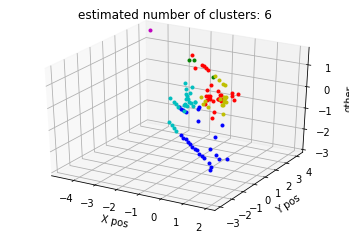

In [11]:
clusters[100].plot()

In [12]:
clusters[99].average_relative_motions

[array([-3.3962748,  3.3874557], dtype=float32),
 array([ 1.0055435 , -0.74502873], dtype=float32),
 array([ 2.3907313, -2.642427 ], dtype=float32),
 array([0., 0.], dtype=float32),
 array([0., 0.], dtype=float32),
 array([-0.08873507, -0.04272373], dtype=float32),
 array([-0.08236582,  0.00433068], dtype=float32),
 array([-0.08873507, -0.04272373], dtype=float32),
 array([-0.08873507, -0.04272373], dtype=float32),
 array([-0.08873507, -0.04272373], dtype=float32),
 array([0., 0.], dtype=float32),
 array([ 0.00526604, -0.01562721], dtype=float32),
 array([0., 0.], dtype=float32),
 array([-0.08873507, -0.04272373], dtype=float32),
 array([-0.08873507, -0.04272373], dtype=float32),
 array([0., 0.], dtype=float32),
 array([0., 0.], dtype=float32),
 array([ 0.00526604, -0.01562721], dtype=float32),
 array([0., 0.], dtype=float32),
 array([ 0.00526604, -0.01562721], dtype=float32),
 array([0., 0.], dtype=float32),
 array([-0.08873507, -0.04272373], dtype=float32),
 array([-0.08873507, -0.04

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ripser import ripser
from persim import plot_diagrams
import persim

def view_profile(speeds):
    X = np.array(list(zip(list(range(len(speeds))), speeds)))
    dgms = ripser(X)['dgms']

    # plt.figure(figsize=(8, 4))
    # plt.subplot(121)
    # plt.scatter(X[:, 0], X[:, 1])
    #plt.axis('equal')
    #plt.title("Point Cloud")
    #plt.subplot(122)
    plot_diagrams(dgms)
    plt.show()
    
    return dgms

In [21]:
fii = scene['frame_index_interval']
aii = frames[fii[0]]['agent_index_interval']

In [22]:
import matplotlib.pyplot as plt

In [23]:
# this needs to be tweaked. we dont need every angular velocity for every car

window = 30
angular_velocities = backpack.AngularVelocityComputer(scene, frames, agents, window=window)

38.26666784286499


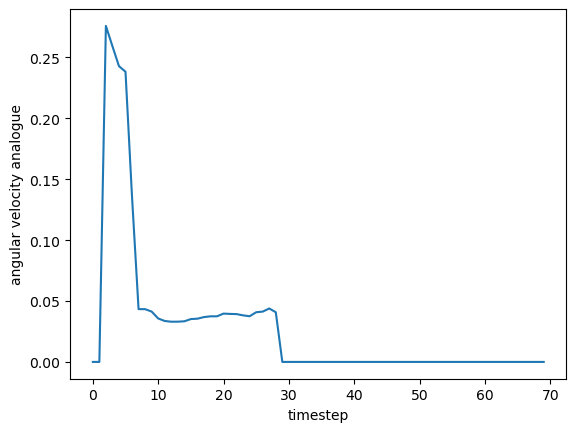

In [24]:
speeds0 = angular_velocities[75]
plt.ylabel('angular velocity analogue')
plt.xlabel('timestep')
plt.plot(list(range(len(speeds0))), speeds0)

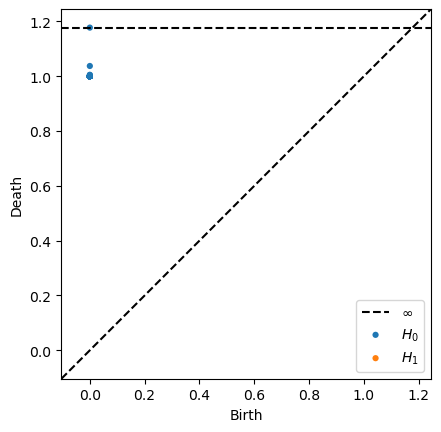

In [25]:
dgm1 = view_profile(speeds0)

In [ ]:
speeds1 = angular_velocities[490]
plt.ylabel('angular velocity analogue')
plt.xlabel('timestep')
plt.plot(list(range(len(speeds))), speeds1)

In [ ]:
dgm2 = view_profile(speeds1)

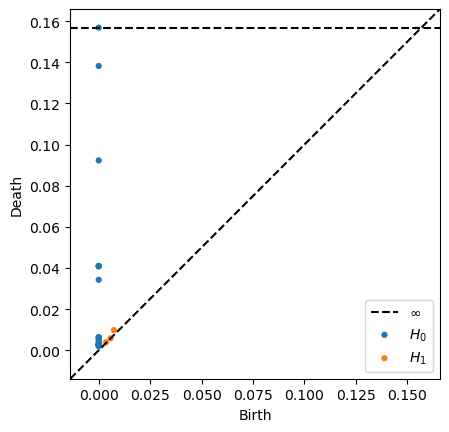

In [108]:
window_size = 10
index = 75

fun = []

for i in range(window_size, len(angular_velocities[index])):
    fun.append(np.array(list(map(lambda ai: angular_velocities[index][ai], range(i-5, i)))))

fun = np.array(fun)

dgms = ripser(fun)['dgms']
plot_diagrams(dgms)
plt.show()

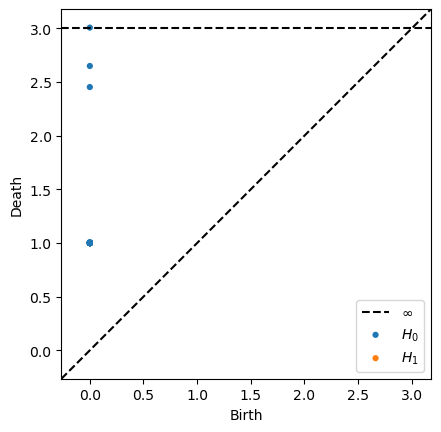

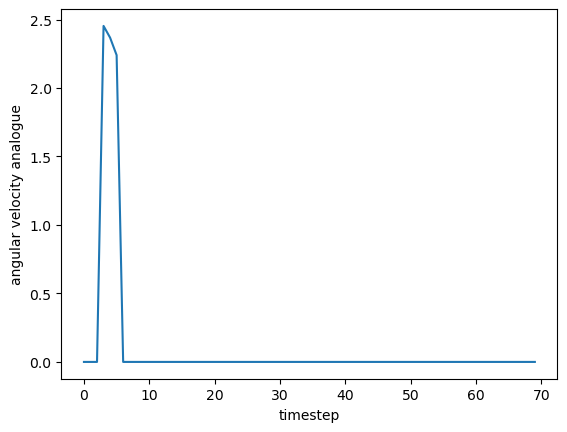

In [104]:
vels = angular_velocities[100]
view_profile(vels);
plt.ylabel('angular velocity analogue')
plt.xlabel('timestep')
plt.plot(list(range(len(vels))), vels)

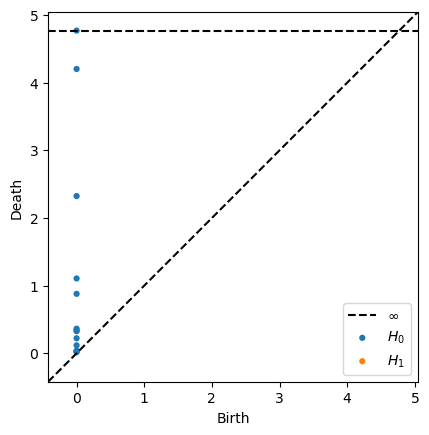

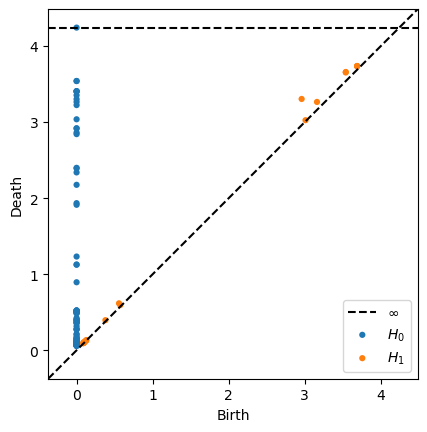

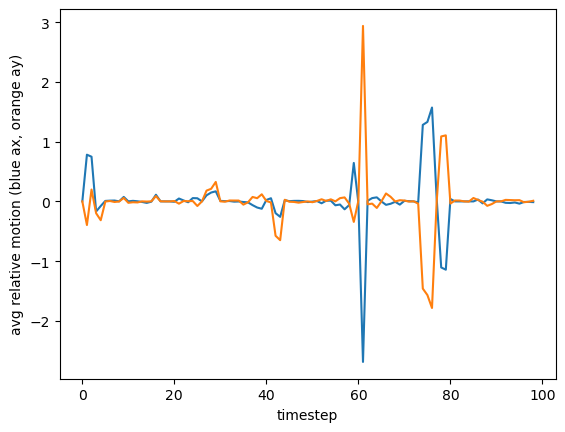

In [111]:
yeet = []
asdf = []
vx = []
vy = []

# agent_i = 24
agent_i = 24

for i in range(99):
    yeet.append(np.linalg.norm(clusters[i].average_relative_motions[agent_i]))
    vx.append(clusters[i].average_relative_motions[agent_i][0])
    vy.append(clusters[i].average_relative_motions[agent_i][1]) 

yeet = []

window_size = 10

for i in range(window_size, 99):
    last_couple = list(map(lambda ai: np.linalg.norm(clusters[ai].average_relative_motions[agent_i]), range(i-window_size, i)))
    yeet.append(np.array(last_couple))
    
# print(clusters[i].average_relative_motions)

yeet = np.array(yeet)

dgms = ripser(np.array(clusters[i].average_relative_motions))['dgms']
plot_diagrams(dgms)
plt.show()

dmgs = ripser(yeet)['dgms']
plot_diagrams(dmgs)
plt.show()

ax = plt.axes()

ax.set_xlabel('timestep')
ax.set_ylabel('avg relative motion (blue ax, orange ay)')

ax.plot(list(range(99)), vx)
ax.plot(list(range(99)), vy)